- E. David Guzmán Ramírez
- Ciencia de Datos
- IIMAS, UNAM

# COVID fact-checker

- [Datos](#Datos)
  - [Twitter](#Twitter)
  - [Limpieza](#Limpieza)
  - [Visualizaciones](#Visualizaciones)
    - [Wordcloud](#Wordclouds)
    - [Mapas](#Mapas)
    - [Tweet info](#Tweet_info)
- [Modelos](#Modelos)
  - [Preparación del texto](#Preparacion_del_texto)
  - [Bag of words](#Bag_of_words)
  - [Desbalance y oversampling](#Desbalance_y_oversampling)
  - [Clasificadores](#Clasificadores)
  - [Hiperparámetros](#Hiperparametros)
- [Resultados](#Resultados)
- [Despliegue](#Despliegue)
- [Trabajo futuro](#Trabajo_futuro)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, get_single_color_func
import folium

import tweepy
from os import listdir
from os.path import isfile

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
import string
import ast
import emoji
from autocorrect import Speller
from google_trans_new import google_translator  

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from joblib import dump, load 
from tqdm import trange, tqdm

sns.set_theme(style='darkgrid')

# To plot using LaTeX, sometimes it gives trouble, in that case comment these two lines
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# For my jupyter theme
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

<a name = "Datos"></a>
## Datos

Los datos se encuentran en [COVID-19 Fake News Dataset](https://www.kaggle.com/arashnic/covid19-fake-news?select=NewsRealCOVID-19_tweets_5.csv). tiene afirmaciones cortas relacionadas con el COVID-19 que han sido clasificadas como reales o falsas. El dataset está dividido en *Claims* y *Tweets*.

### Claims

Son afirmaciones que vienen principalmente de artículos y sitios de noticias, por el momento sólo que hay que juntarlos en un mismo archivo por comodidad.

In [82]:
claims_files = [f for f in listdir('Datos/Inglés/Claims/')]

true_claims = [pd.read_csv('Datos/Inglés/Claims/{}'.format(file)) for file in claims_files
               if 'Real' in file]
fake_claims = [pd.read_csv('Datos/Inglés/Claims/{}'.format(file)) for file in claims_files
               if 'Fake' in file]

true_claims = pd.concat(true_claims, axis=0, ignore_index=True)
fake_claims = pd.concat(fake_claims, axis=0, ignore_index=True)

true_claims['label'] = 1
fake_claims['label'] = 0

true_claims = true_claims[['text', 'label']]
fake_claims = fake_claims[['text', 'label']]

true_claims.dropna(inplace=True)
fake_claims.dropna(inplace=False)

data_claims = pd.concat([true_claims, fake_claims], axis=0, ignore_index=True)
data_claims.to_csv('Datos/Inglés/Claims.csv', index=False)

<a name = "Twitter"></a>
### Twitter

En el dataset no viene el texto del tweet, sino que viene el id del tweet, el cual se puede obtener usando la API de Twitter. Hay que notar que:

- En los archivos de `tweets_replies` lo que importa es el tweet original, no las replies.
- Varios de los tweets han sido borrados, por lo que no los puedo extraer. En caso de que el tweet haya sido borrado la API de Twitter sólo regresa el id del tweet en el archivo json que manda.

Ahora hay que descargar los tweets.

In [55]:
API_key = ''
API_secret_key = ''
Access_token = ''
Access_token_secret = ''

In [56]:
auth = tweepy.OAuthHandler(API_key, API_secret_key)
auth.set_access_token(Access_token, Access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [87]:
# Ponemos todo en un mismo archivo por comodidad
tweets_files = [f for f in listdir('Datos/Inglés/Twitter/')]

true_tweets = [pd.read_csv('Datos/Inglés/Twitter/{}'.format(file))[['tweet_id']]
               for file in tweets_files if 'Real' in file]
false_tweets = [pd.read_csv('Datos/Inglés/Twitter/{}'.format(file))[['tweet_id']]
               for file in tweets_files if 'Fake' in file]

true_tweets = pd.concat(true_tweets, ignore_index=True)
false_tweets = pd.concat(false_tweets, ignore_index=True)

true_tweets.drop_duplicates(inplace=True)
false_tweets.drop_duplicates(inplace=True)

true_tweets['label'] = 1
false_tweets['label'] = 0

data = pd.concat([true_tweets, false_tweets], ignore_index=True)
data.head()

,tweet_id,label
0,1276612275986546688,1
1,1276144323067736064,1
2,1276158755122618370,1
3,1276158614315634690,1
4,1269181439859458048,1


Hay que notar que los datos están bastante desbalanceados, siendo la mayoría afirmaciones verdaderas acerca del COVID.

In [88]:
data['label'].value_counts()

1    144996
0     10899
Name: label, dtype: int64

Lo importante es el texto del tweet para poder entrenar el modelo, pero guardaré algunos otros atributos para hacer algunas visualizaciones. Tarda como hora y media en descargar todos los tweets.

In [91]:
# La API de Twitter sólo permite descargar tweets en paquetes de máximo 100, 
# así que los iré descargando en paquetes de 100
indices = [min(100*i, data.shape[0]-1) for i in range(data.shape[0]//100 + 2)]
# DataFrame donde guardaré lo que necesito de los tweets
data_tweets = pd.DataFrame(columns=['tweet_id', 'text', 'label', 'created_at', 
                                    'country', 'coordinates', 'hashtags'])

for i in trange(len(indices)-1):
    i_min, i_max = indices[i], indices[i+1]
    tweets_ids = data['tweet_id'].tolist()[i_min:i_max]
    labels = data['label'].tolist()[i_min:i_max]
    # El modo 'extended' es importante porque si no trunca los tweets más largos
    tweets = api.statuses_lookup(tweets_ids, tweet_mode='extended', map_=True)
    
    for tweet,label in zip(tweets, labels):
        # Si el json sólo tiene el id el tweet ha sido eliminado 
        if len(tweet._json) == 1:
            pass
        else:
            tweet_id = tweet._json['id']
            text = tweet._json['full_text']
            created_at = tweet._json['created_at']
            
            place = tweet._json.get('place')
            if place is None:
                country = None
            else:
                country = place.get('country')
                
            coordinates = tweet._json['coordinates']
            hashtags = tweet._json['entities']['hashtags']
                        
            data_tweets.loc[len(data_tweets)] = [tweet_id, text, label, created_at, 
                                                 country, coordinates, hashtags]
            
    data_tweets.to_csv('Datos/Inglés/Tweets.csv', index=False)

100%|██████████| 1559/1559 [00:00<00:00, 1260150.31it/s]


Por alguna razón algunas labels se desfasaron y tienen la etiqueta equivocada, pero se arregla de manera fácil.

In [92]:
dict_tweet_id_labels = dict(zip(data['tweet_id'].values, data['label'].values))
labels = [dict_tweet_id_labels[x] for x in data_tweets['tweet_id']]

data_tweets['label'] = labels

También hay unos tweets no se escriben bien en el csv, así que los quitaré (si se corre de nuevo toda la notebook es probable que esos índices cambien ya que algunos tweets se habrán eliminado).

In [ ]:
data_tweets.drop([20898, 83375], inplace=True)
data_tweets.to_csv('Datos/Inglés/Tweets.csv', index=False)

<a name = "Limpieza"></a>
### Limpieza

- Hay símbolos raros que debo quitar, como: Ò,Ó,Ô,Õ,Ñ. Debe ser problema de la codificación a la hora en que recolectaron los datos.
- Quitar algunos simbolos que definitivamente no me sirven y puede que hasta causen problemas: "", |, – (guión largo), |.
- Quitar emojis.
- Quitar caractéres en otros idiomas (chino, japonés, árabe)
- Quitar urls.
- Quitaré las preguntas. En los datos originales a veces vienen urls con la respuesta a la pregunta o en el mismo texto viene la url y lo que está en la url es lo que clasifican como `fake` o `real`, pero debería hacer web scraping y en realidad no son tantas las preguntas que hay para que valga el esfuerzo.
- Las otras cosas las dejaré hasta preparar el modelo (quitar símbolos de puntuación, tokenizar, lematizar, etc), así puedo usar estos datos después para otra tarea o alguien más los puede aprovechar.
- Hay varios autocorrectores, el de [SpaCy](https://spacy.io/universe/project/contextualSpellCheck) se ve bien ya que usa Bert, pero cambia demasiado los nombres propios y otras entidades (por ejemplo, **Trump** y **covid** los cambia a **you** e **it** respectivamente, prefiero quedarme con el nombre y no el pronombre). Uno más sencillo es [autocorrect](https://github.com/fsondej/autocorrect), que si no reconoce algo lo deja como está, es probable que se me vayan más errores ortográficos con esta librería pero dejará lo importante intacto, así que la prefiero.

In [56]:
claims = pd.read_csv('Datos/Inglés/Claims.csv', dtype={'label':int})
tweets = pd.read_csv('Datos/Inglés/Tweets.csv', usecols=['text', 'label'], 
                     dtype={'label':int})

data = pd.concat([claims, tweets], ignore_index=True)

In [126]:
def remove_symbols(text):
    return re.sub('[ÒÓÔÕÑÉ\[\]"“”|–]', '', text)

def remove_emojis(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])

    return clean_text

def remove_foreign(text):
    regex = re.compile('[^\u0020-\u024F]') # Parece quitar emojis también
    return regex.sub('', text)

def remove_urls(text):
    regex_pattern = r'http\S+'
    return re.sub(regex_pattern, '', text)

spell = Speller(lang='en', fast=True)
def spell_check(text):    
    return spell(text)

In [127]:
data['text'] = data['text'].apply(lambda text: remove_symbols(text))
data['text'] = data['text'].apply(lambda text: remove_emojis(text))
data['text'] = data['text'].apply(lambda text: remove_foreign(text))
data['text'] = data['text'].apply(lambda text: remove_urls(text))
data['text'] = data['text'].apply(lambda text: spell_check(text))

In [128]:
# Remover las que tienen preguntas
questions = [i for i,text in enumerate(data['text']) if '?' in text]
print('% preguntas: {:.2f}'.format(100*len(questions)/len(data)))
data.drop(questions, inplace=True)

% preguntas: 14.85


Ahora, hay muchos que dicen lo mismo pero se diferencian en un signo o algo por el estilo, lo que ocasiona que aparezcan dos o más veces, lo mejor es quitarlos.

In [129]:
def standardize(text):
    standard_text = text.lower()
    standard_text = re.sub('#\w+', '', standard_text)               # Remove hashtags
    standard_text = re.sub('@\w+', '', standard_text)               # Remove usernames
    standard_text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',  # Remove punctuation
                           '', standard_text)
    standard_text = re.sub('[ \t\n\r\x0b\x0c]', '', standard_text)  # Remove whitespaces
    
    return standard_text

In [130]:
data_copy = data.copy()
data_copy['text'] = data_copy['text'].apply(lambda text: standardize(text))
data_copy.drop_duplicates(inplace=True)
indices = data_copy.index

También quitaré aquellos que tienen una longitud pequeña (menor a 40 parece ser un buen umbral haciendo pruebas), ya que no aportan nada y parecen ruido.

In [131]:
data_clean = data.loc[indices]
data_clean = data_clean.reset_index(drop=True)

# Debajo de esa longitud no aportan nada, así que los quitaré
min_length = [i for i,text in enumerate(data_clean['text']) if len(text) < 40]
data_clean.drop(min_length, inplace=True)

Ahora ya parecen estar limpios, aunque sí se fueron bastantes datos (principalmente porque había muchos tweets repetidos). Al final quedaron

De una vez los dividiré en entrenamiento y prueba.

In [136]:
X_train, X_test, y_train, y_test = train_test_split(
                                 data_clean[['text']], 
                                 data_clean['label'], 
                                 test_size=0.20, 
                                 random_state=42,
                                 stratify=data_clean['label'])

X_train['label'] = y_train
X_test['label'] = y_test

X_train.to_csv('Datos/Inglés/Limpios/train.csv', index=False)
X_test.to_csv('Datos/Inglés/Limpios/test.csv', index=False)

<a name="Visualizaciones"></a>

### Visualizaciones

Las siguientes clases las tomé de [Colored by Group Example](https://amueller.github.io/word_cloud/auto_examples/colored_by_group.html#sphx-glr-auto-examples-colored-by-group-py)

<a name="Wordclouds"></a>

#### Wordclouds

In [2]:
data = pd.read_csv('Datos/Inglés/Limpios/data.csv')

In [3]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [4]:
stopwords_list = pd.read_csv('Datos/my_stopwords.txt', names=['my_stopwords'])
stopwords_list = stopwords_list['my_stopwords'].values.tolist()

all_words = [word.lower() for sentence in data['text'] for word in sentence.split() 
             if word.lower() not in stopwords_list]
fake_words = [word.lower() for sentence in data['text'][data['label'] == 0] 
              for word in sentence.split() if word.lower() not in stopwords_list]
real_words = [word.lower() for sentence in data['text'][data['label'] == 1] 
              for word in sentence.split() if word.lower() not in stopwords_list]

most_common = [x[0] for x in Counter(all_words).most_common(200)]
most_fake = [x[0] for x in Counter(fake_words).most_common(100)]
most_real = [x[0] for x in Counter(real_words).most_common(50)]

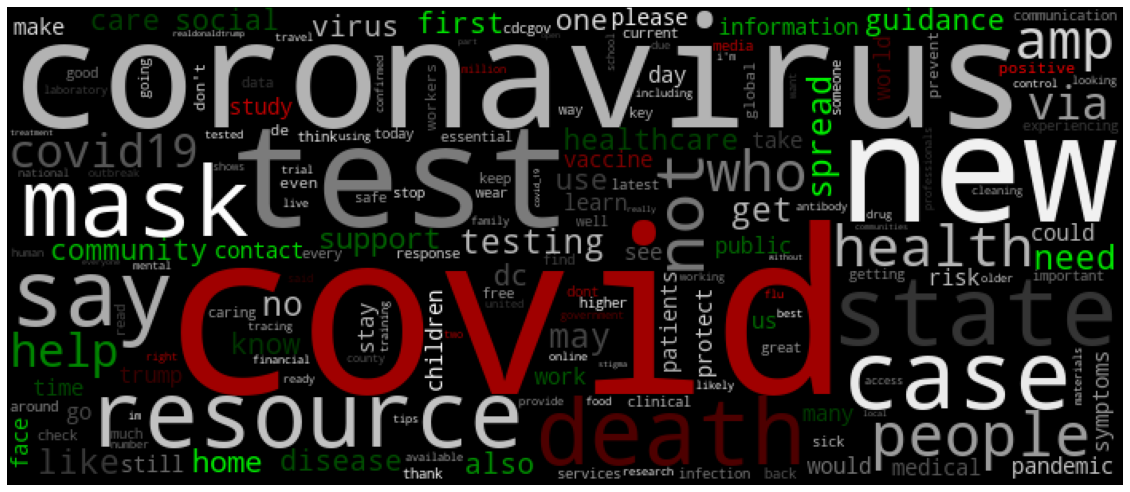

In [5]:
only_fake = set(most_fake) - set(most_real)
only_real = set(most_real) - set(most_fake)

color_to_words = {'green': list(only_real), 'red': list(only_fake)}
default_color = 'grey'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

text = ' '.join(most_common)

wc = WordCloud(random_state=42, stopwords=[], width=700, height=300).generate(text.lower())
wc.recolor(color_func=grouped_color_func)

plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

wc.to_file('Images/cloud.png')

<a name="Mapas"></a>

### Estadísticas básicas

In [76]:
data_tweets = pd.read_csv('Datos/Inglés/Tweets.csv')
data_clean = pd.read_csv('Datos/Inglés/Limpios/data.csv')

Podemos ver que la mayoría de los tweets vienen de Estados Unidos, lo que puede sesgar un poco el clasificador.

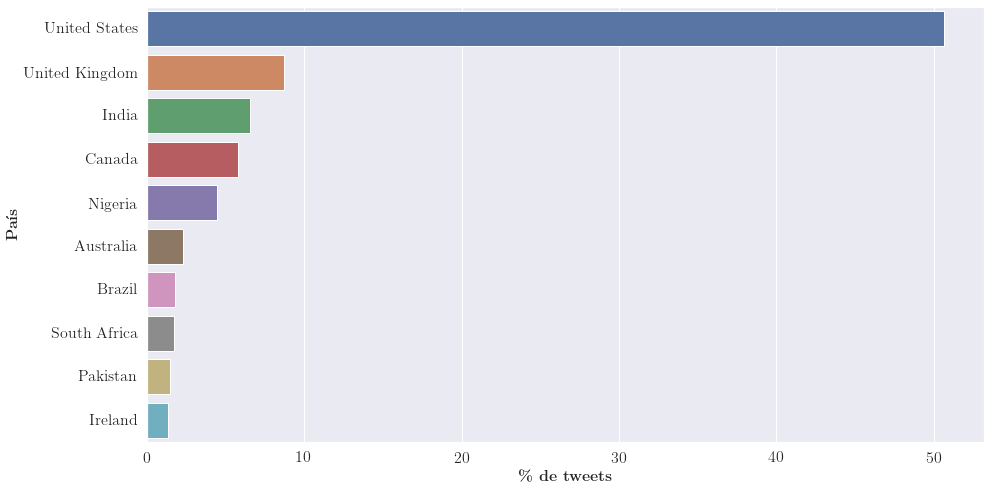

In [241]:
df = data_tweets.dropna(subset=['country'])
df = data_tweets.groupby('country')['country'].count().sort_values(ascending=False)
df = df.to_frame()
df.columns = ['count']
df = df.reset_index()
df['count'] = 100*df['count']/df['count'].sum()
df = df.loc[0:9]

plt.figure(figsize=(15,8))
sns.barplot(y='country', x='count', data=df)
plt.ylabel(r'\textbf{País}', size=16, labelpad=2)
plt.xlabel(r'\textbf{\% de tweets}', size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.savefig('Images/Tweets_by_country.png', bbox_inches='tight')
plt.show()

Veamos cómo está la distribución de `fake` y `real` en cada país. Podemos ver que que en casi todos es muy similar.

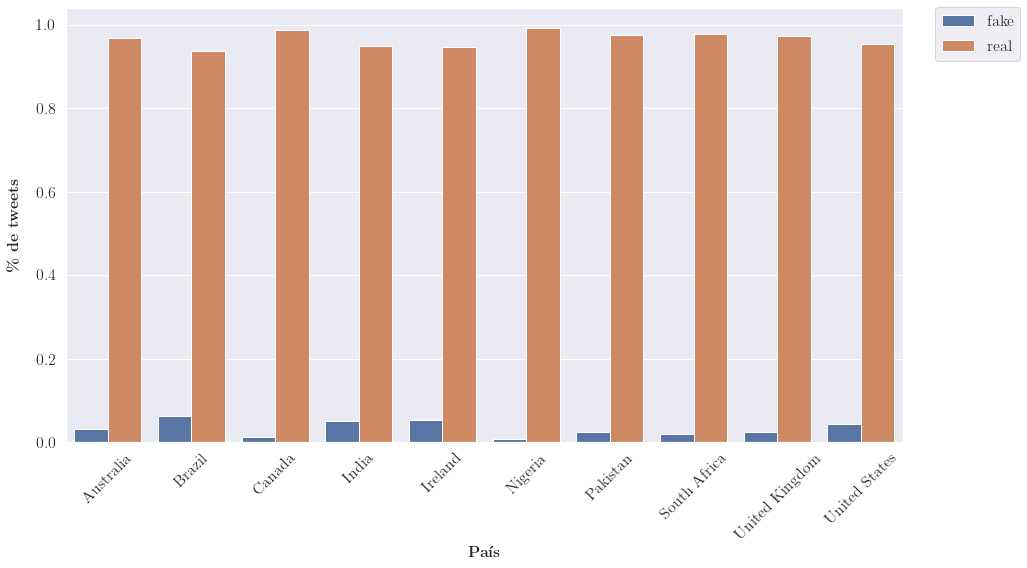

In [78]:
top_10 = ['United States', 'United Kingdom', 'India', 'Canada', 'Nigeria', 
          'Australia', 'Brazil', 'South Africa', 'Pakistan', 'Ireland']

df = data_tweets[data_tweets['country'].apply(lambda x: (x in top_10))]
df = df.dropna(subset=['country'])
df['count'] = np.ones(df.shape[0])
df = df.groupby(by=['country', 'label']).sum()
df = df.reset_index()

sum_by_country = np.array([df[df['country'] == x]['count'].sum() for x in df['country']])
df['count'] = df['count']/sum_by_country
df['label'] = df['label'].replace({0:'fake', 1:'real'})

plt.figure(figsize=(15,8))
sns.barplot(x='country', y='count', data=df, hue='label')
plt.xlabel(r'\textbf{País}', size=16)
plt.ylabel(r'\textbf{\% de tweets}', size=16, labelpad=15)
plt.xticks(size=16, rotation=45)
plt.yticks(size=16)
plt.legend(fontsize=16, bbox_to_anchor=(1.15, 1.02))
plt.show()

Los datos están muy desbalanceados, siendo sólo 5% `fake`. Es un problema que trataré más adelante.

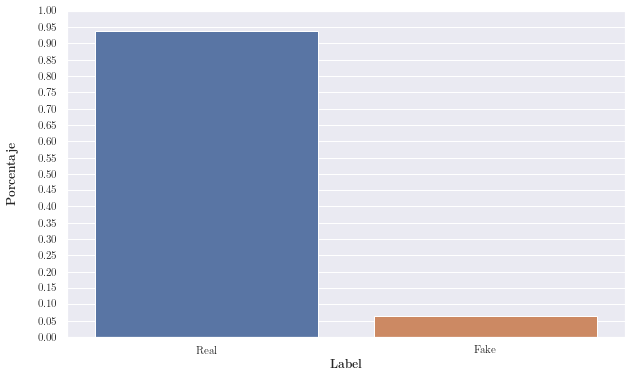

In [79]:
df_count = data['label'].value_counts(normalize=True).to_frame()
df_count['name'] = ['Real', 'Fake']

plt.figure(figsize=(10,6))
sns.barplot(x='name', y='label', data=df_count)
plt.xlabel(r'\textbf{Label}')
plt.ylabel(r'\textbf{Porcentaje}', labelpad=20)
plt.yticks(np.arange(0, 1.05, step=0.05))
plt.savefig('Images/Imbalance.png', bbox_inches='tight')
plt.show()

<a name="Tweet_info"></a>

Ahora hagamos un mapa para ver de dónde vienen los tweets (desafortunadamente no son muchos los tweets con coordenadas).

In [229]:
df = data_tweets.dropna(subset=['coordinates'])

coordinates = [ast.literal_eval(x)['coordinates'] for x in df['coordinates']]

m = folium.Map(location=[0,0], zoom_start=1)

for text,label,coordinate in zip(df['text'], df['label'], coordinates):
    if label == 0:
        color = 'red'
    else:
        color = 'blue'
        
    folium.Marker(
        location=coordinate[::-1],
        tooltip='Click me',
        popup=text[0:50] + '...', # Reducimos la longitud del texto 
        icon=folium.Icon(color=color, icon='comment', prefix='fa'),
        ).add_to(m)

m.save('Images/Tweet_map.html')

m

Y veamos su distribución en el tiempo:

In [254]:
df = data_tweets[['created_at', 'label']]
df = pd.to_datetime(df['created_at']).to_frame()
df['label'] = data_tweets['label']

years = [x.year for x in df['created_at']]
months = [x.month for x in df['created_at']]
days = [x.day for x in df['created_at']]

df['year'] = years
df['month'] = months
df['day'] = days

df = df.sort_values(by=['year', 'month', 'day'])

df_real = df[df['label'] == 1]
df_real = df_real.groupby(by=['year', 'month', 'day']).count().reset_index()
dates_real = [str(day)+'/'+str(month)+'/'+str(year) for day,month,year 
              in zip(df_real['day'],df_real['month'],df_real['year'])]

df_fake = df[df['label'] == 0]
df_fake = df_fake.groupby(by=['year', 'month', 'day']).count().reset_index()
dates_fake = [str(day)+'/'+str(month)+'/'+str(year) for day,month,year 
              in zip(df_fake['day'],df_fake['month'],df_fake['year'])]

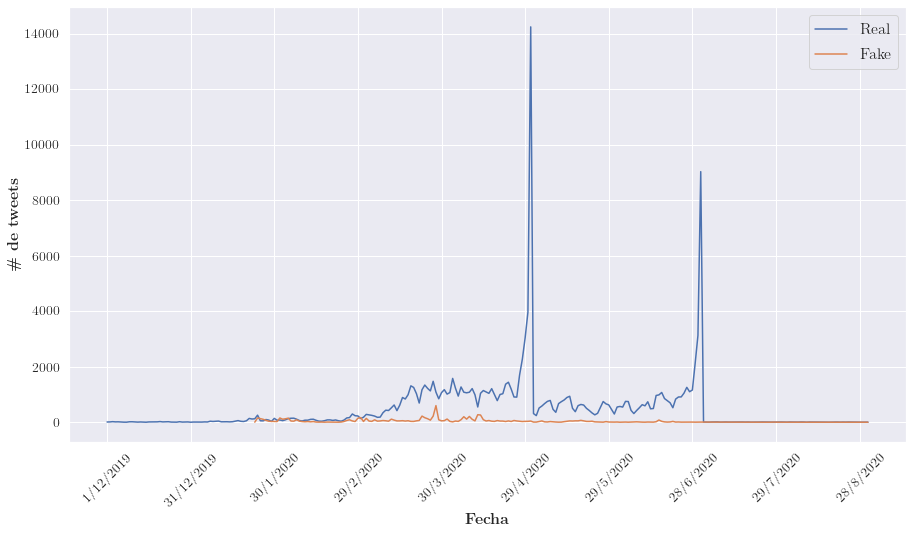

In [255]:
plt.figure(figsize=(15,8))
plt.plot(dates_real, df_real['created_at'], label='Real')
plt.plot(dates_fake, df_fake['created_at'], label='Fake')

plt.xticks(np.arange(0, df_real.shape[0], 30), rotation=45, size=14)
plt.yticks(size=14)
plt.xlabel(r'\textbf{Fecha}', size=16)
plt.ylabel(r'\textbf{\# de tweets}', size=16)
plt.legend(fontsize=16)
plt.savefig('Images/tweet_time.png', bbox_inches='tight')
plt.show()

<a name="Modelos"></a>

## Modelos

Primero que nada hay que preparar el texto (al hacer la predicción debo realizar estos pasos con el texto que se ingrese):

- Pasar a minúsculas.
- Quitar signos de puntuación.
- Quitar stopwords. Las stopwords que sirven para negar (como *no, not, can't, etc*) son importantes para mi problema, de modo que esas no las quitaré.
- Lematizar. Hice algunas pruebas y lematizar mejoraba levemente el rendimiento, pero no era una gran mejoría. En cualquier caso es una mejoría así que lematizaré.

<a name="Preparacion_del_texto"></a>

### Preparación del texto

In [211]:
train = pd.read_csv('Datos/Inglés/Limpios/train.csv')
test = pd.read_csv('Datos/Inglés/Limpios/test.csv')

In [212]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)
lemmatizer = WordNetLemmatizer() 
stopwords_list = pd.read_csv('Datos/my_stopwords.txt', names=['my_stopwords'])
stopwords_list = stopwords_list['my_stopwords'].values.tolist()

def prepare_text(text):
    # Convert to lowercase
    clean_text = text.lower()
    # Remove punctuation, keep @ because TweetTokenizer handles it
    clean_text = re.sub('[!"#$%&\'()*+,-./:;<=>?[\\]^_`{|}~]', '', clean_text)
    # Remove whitespaces
    clean_text = re.sub('[\t\n\r\x0b\x0c]', '', clean_text)
    # Tokenize
    clean_text = tokenizer.tokenize(clean_text)
    # Remove stopwords
    clean_text = [word for word in clean_text if word not in stopwords_list]
    # Lemmatizer
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    # Put together again
    clean_text = ' '.join(clean_text)
    
    return clean_text

In [213]:
%time train['text'] = train['text'].apply(lambda text: prepare_text(text))
%time test['text'] = test['text'].apply(lambda text: prepare_text(text))

CPU times: user 11.2 s, sys: 548 ms, total: 11.7 s
Wall time: 11.8 s
CPU times: user 2.8 s, sys: 108 ms, total: 2.91 s
Wall time: 2.92 s


In [214]:
X_train, y_train = train[['text']], train['label'].values
X_test, y_test = test[['text']], test['label'].values

<a name="Bag_of_words"></a>
### Bag of words

Hay distintas formas de vectorizar un texto, una de ellas se conoce como **bag of words**, donde un corpus de documentos puede representarse mediante una matriz con una fila por documento y una columna por palabra en el corpus.

![BOW](Images/bow.png)

En un corpus de texto grande, algunas palabras estarán muy presentes, por lo que contienen muy poca información significativa sobre el contenido real del documento. Esos términos muy frecuentes restarían importancia a las frecuencias de términos más raros pero más interesantes. Para resolver el problema, es muy común utilizar la transformación **tf-idf**.

In [215]:
words_train = [word for sentence in train['text'] for word in tokenizer.tokenize(sentence)]
vocab_train = set(words_train)

len(vocab_train)

58120

In [216]:
word_vectorizer = TfidfVectorizer(
                sublinear_tf=False,
                strip_accents='unicode',
                analyzer='word',
                ngram_range=(1,5),
                max_features=10000)

%time word_vectorizer.fit(X_train.values.squeeze())
%time X_train = word_vectorizer.transform(X_train.values.squeeze())

CPU times: user 11.6 s, sys: 276 ms, total: 11.9 s
Wall time: 11.9 s
CPU times: user 2.96 s, sys: 0 ns, total: 2.96 s
Wall time: 2.96 s


<a name="Desbalance_y_oversampling"></a>

### Desbalance y oversampling

Sólo el 5% de los datos están etiquetados como `fake`, lo que puede ser un problema para el clasificador, ya que puede marcar la mayoría como `real`.

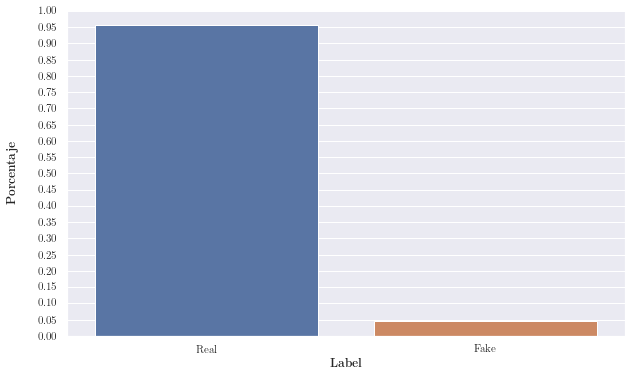

In [217]:
df_count = train['label'].value_counts(normalize=True).to_frame()
df_count['name'] = ['Real', 'Fake']

plt.figure(figsize=(10,6))
sns.barplot(x='name', y='label', data=df_count)
plt.xlabel(r'\textbf{Label}')
plt.ylabel(r'\textbf{Porcentaje}', labelpad=20)
plt.yticks(np.arange(0, 1.05, step=0.05))

plt.show()

Una técnica ampliamente adoptada para tratar con conjuntos de datos altamente desequilibrados se llama remuestreo. Consiste en eliminar muestras de la clase mayoritaria (oversampling) y/o agregar más ejemplos de la clase minoritaria (undersampling).

![Resampling](Images/resampling.png)

En este caso haré un oversampling de la clase `fake` (únicamente se hace en el de training) para que las clases queden aproximadamente como

- `Real`: 70%
- `Fake`: 30%

In [218]:
smote = SMOTE(sampling_strategy=0.43, random_state=42)
X_train, y_train = smote.fit_sample(X_train, y_train)

In [219]:
# Están 30%-70% como quería
pd.DataFrame(y_train).value_counts(normalize=True)

1    0.699307
0    0.300693
dtype: float64

<a name="Clasificadores"></a>

### Clasificadores

Haciendo experimentos, hacer oversampling sí funciona para subir el rendimiento. SVM con un kernel lineal o radial parecen ser los mejores, para el despliegue con streamlit usaré el kernel lineal ya que el radial puede ser un poco tardado (no mucho, pero en el caso de que suba un csv puede tardar algo).

Por el momento estoy tratando de maximizar mi verdaderos negativos $C_{0,0}$ (después de todo lo que me interesa es identificar los fakes) y minimizar los elementos fuera de la diagonal. 

A mi parecer, los falsos positivos $C_{0,1}$ (digo que es real cuando es fake) son más dañinos que los falsos negativos $C_{1,0}$ (digo que es fake cuando es real), de modo que es preferible también disminuir $C_{0,1}$.


- SVM (lineal)
  - Con oversampling: $\left( \begin{matrix}
614 & 63 \\ 
62 & 14444
\end{matrix}  \right)$
  - Sin oversampling: $\left( \begin{matrix}
589 & 88 \\ 
15 & 14491
\end{matrix}  \right)$
- SVM (radial)
  - Con oversampling: $\left( \begin{matrix}
562 & 115 \\ 
5 & 14501
\end{matrix}  \right)$
  - Sin oversampling: $\left( \begin{matrix}
534 & 143 \\ 
1 & 14505
\end{matrix}  \right)$
- RandomForest
  - Con oversampling: $\left( \begin{matrix}
546 & 131 \\ 
9 & 14497
\end{matrix}  \right)$
  - Sin oversampling: $\left( \begin{matrix}
507 & 170 \\ 
7 & 14499
\end{matrix}  \right)$
- KNN
  - Con oversampling: $\left( \begin{matrix}
563 & 114 \\ 
116 & 14390
\end{matrix}  \right)$
  - Sin oversampling: $\left( \begin{matrix}
467 & 210 \\ 
4 & 14502
\end{matrix}  \right)$

In [36]:
clf_svm_linear = LinearSVC(C=1, penalty='l2', random_state=42)
%time clf_svm_linear.fit(X_train, y_train)

clf_svm = SVC(C=1, random_state=42)
%time clf_svm.fit(X_train, y_train)

clf_rfc = RandomForestClassifier(random_state=42)
%time clf_rfc.fit(X_train, y_train)

# euclidean funciona mejor que cosine
clf_knn = KNeighborsClassifier(metric='euclidean', weights='distance')
%time clf_knn.fit(X_train, y_train)

CPU times: user 160 ms, sys: 4.01 ms, total: 164 ms
Wall time: 164 ms
CPU times: user 5min 32s, sys: 160 ms, total: 5min 32s
Wall time: 5min 33s
CPU times: user 36.8 s, sys: 8.05 ms, total: 36.8 s
Wall time: 36.8 s
CPU times: user 2.9 ms, sys: 3.55 ms, total: 6.45 ms
Wall time: 6.15 ms


KNeighborsClassifier(metric='euclidean', weights='distance')

In [220]:
X_test = word_vectorizer.transform(X_test.values.squeeze())

In [38]:
%time y_pred1 = clf_svm_linear.predict(X_test)
%time y_pred2 = clf_svm.predict(X_test)
%time y_pred3 = clf_rfc.predict(X_test)
%time y_pred4 = clf_knn.predict(X_test)

CPU times: user 1.1 ms, sys: 13 µs, total: 1.11 ms
Wall time: 550 µs
CPU times: user 14.5 s, sys: 38 µs, total: 14.5 s
Wall time: 14.6 s
CPU times: user 741 ms, sys: 0 ns, total: 741 ms
Wall time: 741 ms
CPU times: user 18 s, sys: 4.29 s, total: 22.3 s
Wall time: 22.4 s


In [39]:
print(confusion_matrix(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred4))

[[  614    63]
 [   62 14444]]
[[  562   115]
 [    5 14501]]
[[  546   131]
 [    9 14497]]
[[  563   114]
 [  116 14390]]


<a name="Hiperparametros"></a>

### Hiperparámetros

Para la métrica usaré el $F_{1}$ score y la curva ROC (dan los mismos hiperparámetros después de probarlos, pero ROC hace mejor el cross validation), debido al desbalance de clases parecen ser de las mejores métricas. Al final los hiperparámetros quedan:

- SVM (lineal)
```
{'C': 1, 
'class_weight': None, 
'penalty': 'l2', 
'random_state': 42}
```
- SVM (radial)
```
{'C': 10,
  'class_weight': None,
  'gamma': 'scale',
  'kernel': 'rbf',
  'random_state': 42}
```

- RandomForest
```
{'criterion': 'gini',
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'n_estimators': 100,
  'random_state': 42}
```

#### SVM (lineal)

In [49]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
              'penalty': ['l1', 'l2'], 
              'class_weight': [None, 'balanced'],
              'random_state':[42]}

clf_svm_linear = LinearSVC()
model_svm_linear = GridSearchCV(estimator=clf_svm_linear, param_grid=param_grid, cv=5, 
                                verbose=5, n_jobs=-1, scoring='roc_auc')
model_svm_linear.fit(X_train, y_train)

model_svm_linear.best_params_, model_svm_linear.best_score_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 109 out of 140 | elapsed:    3.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 138 out of 140 | elapsed:    6.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    6.7s finished


({'C': 1, 'class_weight': None, 'penalty': 'l2', 'random_state': 42},
 0.9997553987768729)

In [48]:
y_pred = model_svm_linear.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[  614    63]
 [   62 14444]]


#### SVM (radial)

In [50]:
param_grid = {'kernel': ['linear', 'rbf'],
              'C': [0.1, 1, 10], 
              'gamma': ['scale', 'auto'],
              'class_weight': [None, 'balanced'],
              'random_state': [42]}

clf_svm = SVC()
model_svm = GridSearchCV(estimator=clf_svm, param_grid=param_grid, cv=5, 
                         verbose=5, n_jobs=-1, scoring='roc_auc')
model_svm.fit(X_train, y_train)

model_svm.best_params_, model_svm.best_score_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
/home/david/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed: 41.2min
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed: 111.5min finished


({'C': 10,
  'class_weight': None,
  'gamma': 'scale',
  'kernel': 'rbf',
  'random_state': 42},
 0.9999558928283105)

In [52]:
y_pred = model_svm.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[  570   107]
 [    4 14502]]


#### RandomForest

In [53]:
param_grid = {'criterion': ['entropy', 'gini'],
              'min_samples_leaf': [1, 5, 10],
              'max_features': ['log2', 'sqrt'],
              'n_estimators': [10, 50, 100], 
              'random_state': [42]}

clf_rfc = RandomForestClassifier()
model_rfc = GridSearchCV(estimator=clf_rfc, param_grid=param_grid, cv=5, 
                         verbose=4, n_jobs=-1, scoring='roc_auc')
model_rfc.fit(X_train, y_train)

model_rfc.best_params_, model_rfc.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.6min finished


({'criterion': 'gini',
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'n_estimators': 100,
  'random_state': 42},
 0.999940349462389)

In [54]:
y_pred = model_rfc.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[  524   153]
 [    1 14505]]


#### KNN

Consume toda mi memoria en sólo unos segundos, así que mejor no lo haré.

In [ ]:
# param_grid = {'n_neighbors': [5],
#               'weights': ['uniform', 'distance'],
#               'metric': ['cosine', 'euclidean']}

# clf_knn = KNeighborsClassifier()
# model_knn = GridSearchCV(estimator=clf_knn, param_grid=param_grid, cv=None, 
#                          verbose=4, n_jobs=-1, scoring='roc_auc')
# model_knn.fit(X_train, y_train)

# model_knn.best_params_, model_svm.best_score_

Finalmente, guardemos todos los mejores modelos para no volver a entrenar y hacer el despliegue fácil.

In [54]:
# Lo necesito para hacer la bolsa de palabras
dump(word_vectorizer, 'Modelos/word_vectorizer.joblib')

dump(model_svm_linear.best_estimator_, 'Modelos/SVM_linear.joblib')
dump(model_svm.best_estimator_, 'Modelos/SVM_radial.joblib')
dump(model_rfc.best_estimator_, 'Modelos/RandomForest.joblib')

['Modelos/word_vectorizer.joblib']

<a name="Resultados"></a>
## Resultados

Usaré el modelo de SVM con kernel lineal, ya que es el que tiene mejores resultados. Algo importante de ver es la curva ROC, ya que es una buena métrica a usar debido al desbalanceo de los datos. Se desempeña bastante bien para detectar las ideas falsas más comúnes.

In [221]:
model = load('Modelos/SVM_linear.joblib')

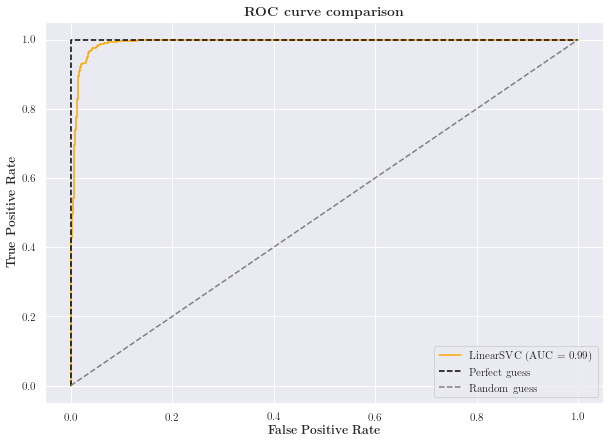

In [261]:
fig, ax = plt.subplots(figsize=(10,7))

plot_roc_curve(model, X_test, y_test, ax=ax, **{'color':'orange'})
plt.plot([0,0,1], [0,1,1], linestyle='--', color='black', label='Perfect guess')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random guess')
ax.set_title(r'\textbf{ROC curve comparison}', size=14)
plt.xlabel(r'\textbf{False Positive Rate}')
plt.ylabel(r'\textbf{True Positive Rate}')
plt.legend()
plt.savefig('Images/ROC.pdf', bbox_inches='tight')
plt.show()

In [231]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       677
           1       1.00      1.00      1.00     14506

    accuracy                           0.99     15183
   macro avg       0.95      0.95      0.95     15183
weighted avg       0.99      0.99      0.99     15183



<div style="text-align: justify">

Hoy en día, las redes sociales proporcionan un terreno particularmente fértil para la difusión de información errónea: carecen de controles y regulaciones, 
los usuarios publican contenido sin tener que pasar por un editor o de revisión por pares, verificación de calificación o suministro de fuentes, y las 
redes sociales tienden a crear *cámaras de eco* o redes cerradas de comunicación aisladas de los desacuerdos.

En el ámbito del periodismo, la *fact-checking* es la tarea de evaluar si las afirmaciones hechas en son verdaderas o falsas. Esta es una tarea que 
normalmente la realizan profesionales capacitados, sin embargo, debido al gran volumen de contenido a verificar, en los últimos años han habido múltiples 
esfuerzos para desarrollar herramientas que automaticen partes de esta tarea
</div>

In [257]:
from sklearn.metrics import f1_score

print(classification_report(y_test, model.predict(X_test), target_names=['fake', 'real']))

print(confusion_matrix(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

        fake       0.91      0.91      0.91       677
        real       1.00      1.00      1.00     14506

    accuracy                           0.99     15183
   macro avg       0.95      0.95      0.95     15183
weighted avg       0.99      0.99      0.99     15183

[[  614    63]
 [   62 14444]]


<a name="Despliegue"></a>

## Despliegue

El despliegue está en en el archivo ```app.py```. Se pueden poner oraciones en inglés o español y las marcará como falsas o verdaderas.

<a name="Trabajo_futuro"></a>
## Trabajo futuro

El modelo funciona pero claramente podría mejorar, especialmente porque en la bolsa de palabras no hay una noción de orden. Para mejorar se podría usar una LSTM y/o embeddings, como en 

- [Text classification with an RNN](https://www.tensorflow.org/tutorials/text/text_classification_rnn)
- [Text classification with TorchText](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)